In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


#### Power Conference Feature

From EDA we know that a small number of conferences account for 70% of all confernece wins. 

If one of the two teams is in a power conference, indicate the advantage that team has for winning the game.

In [3]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: abs(kv[1]))

    return feature_importances_sorted


In [4]:
def display_important_features_regression(classifier, features):
    importances = classifier.coef_[0]
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Coefficient Values')
    for items in feature_importances:
        print(items[0]," ", items[1])

In [6]:

# Note season indicates start of season, e.g. 2013 to 2014, the corresponding tournament season is 1 greater than this value
# The tournament season for season 2013 is 2014
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id.csv'))
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(2773, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
38,2009,Centenary (LA),NaN,29,-17.16,-5.08,0.276,70,80,0.416,0.49,0.733,25,80.641379,9,11,20,27,15,7,86.804071,21


In [7]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(2772, 22)


#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [8]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [9]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)
tourney_data['train_rec'] = 0
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 10 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
train_rec       2117 non-null int64
dtypes: int64(5), object(5)
memory usage: 165.5+ KB


### Extract some historical data

In [10]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [11]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

The summary season data is available from 2010 through 2017.

So the intersection of season summary data with tournament data are seasons 2010-2017.

In [12]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [13]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,0,1,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,0,1,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,0,1,2010
31,2011,16,2011-03-25,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,0,1,2010
33,2011,32,2011-03-20,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,0,1,2010
34,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,0,1,2010
35,2011,68,2011-03-16,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,0,1,2010
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,0,1,2015


In [14]:
# We need to recode the game data so that we have representation of the losing game result class.
# Swap the team and opp team data on the odd rows and reverse the sense of the game result.

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data.head()

,season,round,game_date,seed_t,team,team_id,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season
10,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010
27,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011
30,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010


In [15]:
tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data.head()

,season,round,game_date,seed_t,team,team_id,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season,Game Result,School,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22


In [16]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))
#tourney_data.info()

In [44]:
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,train_rec,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20


In [17]:
tourney_data.drop(columns=['School_t','School_o','Games_t','Games_o','team_id_o'],inplace=True)
tourney_data.head()

,season_t,round,game_date,seed_t,team,team_id_t,seed_o,opp_team,opp_team_id,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20


Incorporate additional features here.
Team conference, seeding deltas.

In [18]:
tourney_data = tourney_data.join(teams, on='team_id_t', how='left')


In [19]:
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)
tourney_data.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


In [20]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>=2010]
computer_rankings[computer_rankings.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [23]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))
temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3


In [24]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [25]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,0,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,0,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,0,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,0,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,0,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [26]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [27]:
tourney_comp_ratings['srs_sqr_t'] = tourney_comp_ratings['SRS_t'] * tourney_comp_ratings['SRS_t'] 
tourney_comp_ratings['srs_sqr_o'] = tourney_comp_ratings['SRS_o'] * tourney_comp_ratings['SRS_o'] 
tourney_comp_ratings['off_rating_sqr_t'] = tourney_comp_ratings['off_rating_t'] * tourney_comp_ratings['off_rating_t'] 
tourney_comp_ratings['off_rating_sqr_o'] =tourney_comp_ratings['off_rating_o'] * tourney_comp_ratings['off_rating_o'] 

In [29]:
numeric_feature_to_scale = ['pts_avg_t','opp_pts_avg_t',
                            'off_rebs_avg_t','allow_off_rebs_avg_t',
                            'def_rebs_avg_t','allow_def_rebs_avg_t',
                            'ft_att_avg_t','allow_ft_att_avg_t',
                            'to_avg_t','steal_avg_t',
                            'SRS_t','SAG_t','WLK_t','RTH_t','COL_t','POM_t','DOL_t','RPI_t','MOR_t',
                            'off_rating_t',
                            'pts_avg_o','opp_pts_avg_o',
                            'off_rebs_avg_o','allow_off_rebs_avg_o',
                            'def_rebs_avg_o','allow_def_rebs_avg_o',
                            'ft_att_avg_o','allow_ft_att_avg_o',
                            'to_avg_o','steal_avg_o',
                            'SRS_o', 'SAG_o', 'WLK_o', 'RTH_o', 'COL_o', 'POM_o', 'DOL_o', 'RPI_o', 'MOR_o',
                            'off_rating_o',
                            'srs_sqr_t','srs_sqr_o','off_rating_sqr_t','off_rating_sqr_o']

scaler =StandardScaler()
tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,0,2012,Lose,0.008079,7.17,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,2012,-0.598892,5.20,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,Atlantic Coast,American Athletic,-0.325048,-0.267396,36,-0.273028,-0.145566,-0.133821,-0.152933,-0.104259,-0.371385,0.228719,0.344194,35,0.044980,-0.014656,0.509272,0.081009,0.040149,0.150792,1,0,-0.309298,-0.944152,0.564366,-0.512594
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,0,1,2010,Win,-0.250945,4.23,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,2010,-0.275443,11.45,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,American Athletic,Big Ten,-0.189997,-0.207571,25,-0.199559,-0.250214,-0.074382,-0.295190,-0.171238,0.028357,0.035980,0.017288,43,-0.139723,-0.036235,-0.063474,-0.044935,-0.006120,-0.317577,-1,0,-0.599033,-0.642088,-0.580318,-0.653018
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2012,Lose,-0.808437,0.18,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,2012,0.370138,4.47,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,Mid-American,Atlantic 10,0.388791,0.290966,52,0.296358,0.231170,0.242624,0.131581,0.096677,0.313886,-0.330223,-0.452638,27,-0.324427,-0.295180,-0.418971,-0.212860,-0.353139,-0.523659,0,1,-1.077425,0.167481,-1.058146,-0.343703
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,0,1,2011,Win,-0.719028,0.63,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,2011,0.439824,3.80,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,Atlantic 10,American Athletic,0.157275,0.051668,32,0.204521,-0.082777,0.103934,-0.132611,0.007372,0.218710,-0.638605,-0.636522,16,-0.527601,-0.640441,-0.636220,-0.548709,-0.630755,-0.636068,0,1,-1.014051,0.271334,-1.226306,0.783481
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,0,2010,Lose,1.293993,7.62,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,2010,-0.725115,3.78,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465

In [34]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','team_t','team_id_t',
                                         'team_o','team_id_o','game_result','start_season','Game Result',
                                         'conf_name_t','conf_name_o','train_rec','SOS_t','SOS_o']).copy()
feature_data.head()

,season_t,seed_t,seed_o,SRS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o
0,2013,8,9,0.008079,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,2012,-0.598892,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,-0.325048,-0.267396,36,-0.273028,-0.145566,-0.133821,-0.152933,-0.104259,-0.371385,0.228719,0.344194,35,0.044980,-0.014656,0.509272,0.081009,0.040149,0.150792,1,0,-0.309298,-0.944152,0.564366,-0.512594
1,2011,7,10,-0.250945,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,2010,-0.275443,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,-0.189997,-0.207571,25,-0.199559,-0.250214,-0.074382,-0.295190,-0.171238,0.028357,0.035980,0.017288,43,-0.139723,-0.036235,-0.063474,-0.044935,-0.006120,-0.317577,-1,0,-0.599033,-0.642088,-0.580318,-0.653018
2,2013,12,5,-0.808437,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,2012,0.370138,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,0.388791,0.290966,52,0.296358,0.231170,0.242624,0.131581,0.096677,0.313886,-0.330223,-0.452638,27,-0.324427,-0.295180,-0.418971,-0.212860,-0.353139,-0.523659,0,1,-1.077425,0.167481,-1.058146,-0.343703
3,2012,12,5,-0.719028,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,2011,0.439824,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,0.157275,0.051668,32,0.204521,-0.082777,0.103934,-0.132611,0.007372,0.218710,-0.638605,-0.636522,16,-0.527601,-0.640441,-0.636220,-0.548709,-0.630755,-0.636068,0,1,-1.014051,0.271334,-1.226306,0.783481
4,2011,1,11,1.293993,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,2010,-0.725115,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465,-0.768786,-0.765933,3,-0.750577,-0.794388,-0.767833,-0.762606,-0.818701,-0.771126,0.652744,0.282899,54,0.543680,0.395342,0.825270,0.647755,0.225226,0.675365,1,1,1.762790,-1.043280,1.178463,-0.227863


In [35]:
feature_data_diff = feature_data.copy()
feature_data_diff['margin_victory_t'] = feature_data_diff['pts_avg_t'] - feature_data_diff['opp_pts_avg_t']
feature_data_diff['margin_victory_o'] = feature_data_diff['pts_avg_o'] - feature_data_diff['opp_pts_avg_o']
feature_data_diff['delta_margin_victory_avg'] = feature_data_diff['margin_victory_t'] - feature_data_diff['margin_victory_o']

feature_data_diff['delta_fg_pct'] = feature_data_diff['fg_pct_t'] - feature_data_diff['fg_pct_o']

#feature_data_diff['allow_fg_pct'] = feature_data_diff['allow_fg_pct_t'] - feature_data_diff['allow_fg_pct_o']
feature_data_diff['delta_off_rebs_avg'] = feature_data_diff['off_rebs_avg_t'] - feature_data_diff['off_rebs_avg_o']
feature_data_diff['def_rebs_avg'] = feature_data_diff['def_rebs_avg_t'] - feature_data_diff['def_rebs_avg_o']
feature_data_diff['delta_allow_def_rebs_avg'] = feature_data_diff['allow_def_rebs_avg_t'] - feature_data_diff['allow_def_rebs_avg_o']
feature_data_diff['delta_ft_pct'] = feature_data_diff['ft_pct_t'] - feature_data_diff['ft_pct_o']

feature_data_diff['to_net_avg_t'] = feature_data_diff['to_avg_t'] - feature_data_diff['steal_avg_t']
feature_data_diff['to_net_avg_o'] = feature_data_diff['to_avg_o'] - feature_data_diff['steal_avg_o']
feature_data_diff['delta_to_net_avg'] = feature_data_diff['to_net_avg_t'] - feature_data_diff['to_net_avg_o']

feature_data_diff['delta_win_pct'] = feature_data_diff['win_pct_t'] - feature_data_diff['win_pct_o']
feature_data_diff['delta_off_rating'] = feature_data_diff['off_rating_t'] - feature_data_diff['off_rating_o']

feature_data_diff['delta_allow_off_rebs_avg'] = feature_data_diff['allow_off_rebs_avg_t'] - feature_data_diff['allow_off_rebs_avg_o']
feature_data_diff['delta_ft_att_avg'] = feature_data_diff['ft_att_avg_t'] - feature_data_diff['ft_att_avg_o']

feature_data_diff['delta_allow_ft_att_avg'] = feature_data_diff['allow_ft_att_avg_t'] - feature_data_diff['allow_ft_att_avg_o']

feature_data_diff['delta_seed'] = feature_data_diff['seed_t'] - feature_data_diff['seed_o']

feature_data_diff['delta_srs'] = feature_data_diff['SRS_t'] - feature_data_diff['SRS_o']

feature_data_diff['delta_srs_sqr'] = feature_data_diff['srs_sqr_t'] - feature_data_diff['srs_sqr_o']

feature_data_diff['delta_sag'] = feature_data_diff['SAG_t'] - feature_data_diff['SAG_o']
feature_data_diff['delta_wlk'] = feature_data_diff['WLK_t'] - feature_data_diff['WLK_o']
feature_data_diff['delta_wol'] = feature_data_diff['WOL_t'] - feature_data_diff['WOL_o']
feature_data_diff['delta_rth'] = feature_data_diff['RTH_t'] - feature_data_diff['RTH_o']
feature_data_diff['delta_col'] = feature_data_diff['COL_t'] - feature_data_diff['COL_o']
feature_data_diff['delta_pom'] = feature_data_diff['POM_t'] - feature_data_diff['POM_o']
feature_data_diff['delta_dol'] = feature_data_diff['DOL_t'] - feature_data_diff['DOL_o']
feature_data_diff['delta_rpi'] = feature_data_diff['RPI_t'] - feature_data_diff['RPI_o']
feature_data_diff['delta_mor'] = feature_data_diff['MOR_t'] - feature_data_diff['MOR_o']


feature_data_diff.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_t', 'margin_victory_o',
                                'poss_avg_t','poss_avg_o',
                                'seed_t','seed_o',
                                'fg_pct_t','fg_pct_o','allow_fg_pct_t','allow_fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'allow_def_rebs_avg_t','allow_def_rebs_avg_o','ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'allow_off_rebs_avg_t','allow_off_rebs_avg_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'SRS_t','SRS_o','srs_sqr_t','srs_sqr_o',
                                'allow_ft_att_avg_t','allow_ft_att_avg_o',
                                'SAG_t','SAG_o','WLK_t','WLK_o','WOL_t','WOL_o',
                                'RTH_t','RTH_o','COL_t','COL_o','POM_t','POM_o',
                                'DOL_t','DOL_o','RPI_t','RPI_o','MOR_t','MOR_o'], inplace=True)


In [33]:
feature_data_diff.head()

,season_t,SOS_t,season_o,SOS_o,top_conf,upset_seed_threshold,off_rating_sqr_t,off_rating_sqr_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_srs_sqr,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,7.17,2012,5.20,1,0,0.564366,-0.512594,0.396900,0.068,0.002565,1.204357,-2.423853,-0.042,1.996181,-0.020,1.072918,1.347538,1.076420,-0.370888,-1,0.606971,0.634854,-0.553767,-0.611589,1,-0.318008,-0.130910,-0.643093,-0.233942,-0.144408,-0.522177
1,2011,4.23,2010,11.45,-1,0,-0.580318,-0.653018,1.340356,0.008,1.096821,1.233025,-0.653651,-0.026,-1.483135,0.206,0.073199,2.103235,1.036005,-0.734887,-3,0.024499,0.043055,-0.225978,-0.224859,-18,-0.059836,-0.213980,-0.010908,-0.250255,-0.165118,0.345934
2,2013,0.18,2012,4.47,0,1,-1.058146,-0.343703,-0.605021,0.005,-0.519248,1.190022,-1.252380,-0.058,4.102068,0.038,-0.742247,-0.812591,0.678909,-0.377278,7,-1.178575,-1.244906,0.719014,0.743604,25,0.620785,0.526350,0.661595,0.344441,0.449817,0.837545
3,2012,0.63,2011,3.80,0,1,-1.226306,0.783481,-1.230255,-0.072,1.122137,-2.741534,1.715279,-0.063,-3.866277,-0.012,-2.031666,0.656019,0.311709,-0.016474,7,-1.158852,-1.285386,0.795881,0.688191,16,0.732122,0.557665,0.740154,0.416098,0.638127,0.854777
4,2011,7.62,2010,3.78,1,1,1.178463,-0.227863,2.507435,0.074,0.549693,2.572213,-1.838116,-0.036,1.920863,0.221,1.370881,-0.078286,0.699117,-0.016474,-10,2.019108,2.806069,-1.421530,-1.048832,-51,-1.294258,-1.189729,-1.593103,-1.410361,-1.043927,-1.446491


In [38]:
# 
X= feature_data_diff[feature_data_diff['season_t']>=2010]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(426, 29)
(426,)
(107, 29)
(107,)


,season_o,top_conf,upset_seed_threshold,off_rating_sqr_t,off_rating_sqr_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_srs_sqr,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
140,2009,0,1,0.338257,-0.707030,0.450177,0.069,-1.142322,-0.941617,-3.621311,-0.008,1.325804,0.081,1.052428,-0.833983,-1.534394,-0.731692,-11,1.615448,1.502214,-1.922479,-1.644778,-105,-1.941443,-1.973707,-1.750597,-2.259339,-1.974162,-1.763780
293,2009,0,0,-0.872689,0.133314,-0.543713,0.000,0.600324,-0.048825,-2.449838,-0.044,1.985520,0.030,-1.024815,-3.015505,-0.055491,-0.370888,1,-0.342336,-0.481775,0.217188,0.307342,5,0.088958,0.110351,0.284457,0.067944,0.137249,0.150471
368,2014,-1,1,-0.582434,-1.388465,-0.944750,0.032,-1.689451,0.383237,-0.653651,0.016,1.479134,-0.132,0.846440,-0.099679,-2.676409,0.337941,9,-1.929348,-1.780882,1.606279,1.782523,90,1.889674,1.978291,1.513361,2.042561,1.546230,1.712268
53,2015,1,1,-0.199789,0.696904,0.967795,-0.006,3.857777,1.276028,-0.627666,-0.085,-0.239021,0.118,-0.882773,0.656019,1.800716,1.771573,-8,1.247297,1.458538,-1.055040,-1.423462,-63,-1.277746,-1.542779,-1.177473,-1.378402,-1.172533,-1.012887
33,2016,0,0,0.969214,1.082798,0.359944,-0.007,-0.569879,-0.034491,-0.653651,0.034,-0.699375,-0.015,-0.105227,-0.812591,-0.422691,-1.079717,2,-0.383090,-0.754601,0.159137,0.212045,3,0.182444,0.165842,0.125954,0.262205,0.198876,0.302153


In [40]:
# mark the records used for training
tourney_comp_ratings['train_rec'] = 0
tourney_comp_ratings.loc[X_train.index,'train_rec']= 1

In [41]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-3.96242836e-05 -1.22399937e-01  5.63309206e-02 -8.90237607e-02
  -1.49601202e-01 -4.35281626e-01 -9.16351811e-02  2.94042019e-02
  -1.76849180e-01 -1.49111345e-01 -1.02388812e-01 -8.89557228e-02
   2.56418040e+00 -2.40353830e-01  3.44972347e-02 -1.59939672e-01
  -1.22188667e-01  9.90659604e-02  2.84263877e+00  2.27140044e-01
   4.77071419e-01 -2.57349775e-01 -1.25337366e-02  1.34073386e+00
  -5.72392199e-01  5.50138959e-01  4.07143772e-01 -1.96508063e-01
   1.78138024e-01]]
Intercept  [-0.00348605]


In [42]:
display_important_features_regression(logreg, X_train)

Coefficient Values
delta_srs   2.8426387665694905
delta_win_pct   2.564180397854894
delta_rth   1.3407338609471318
delta_col   -0.5723921992426344
delta_pom   0.5501389585726253
delta_sag   0.47707141850792584
delta_margin_victory_avg   -0.4352816255094209
delta_dol   0.4071437723770607
delta_wlk   -0.25734977491594246
delta_off_rating   -0.24035383038817637
delta_srs_sqr   0.2271400441826916
delta_rpi   -0.19650806289463948
delta_mor   0.1781380244071208
def_rebs_avg   -0.1768491802668579
delta_ft_att_avg   -0.15993967192660621
off_rating_sqr_o   -0.14960120209099978
delta_allow_def_rebs_avg   -0.14911134481486438
top_conf   -0.12239993731496397
delta_allow_ft_att_avg   -0.12218866739195033
delta_ft_pct   -0.10238881219071219
delta_seed   0.09906596036989071
delta_fg_pct   -0.09163518107401088
off_rating_sqr_t   -0.08902376065224828
delta_to_net_avg   -0.08895572276989465
upset_seed_threshold   0.05633092055711519
delta_allow_off_rebs_avg   0.03449723474522514
delta_off_rebs_avg   0.0

In [43]:
y_pred = logreg.predict(X_test)
print("LR model prediction accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

LR model prediction accuracy is 0.72


In [44]:
print("Log loss= ",log_loss(y_test,logreg.predict_proba(X_test)))

Log loss=  0.5582834570159061


In [45]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[39, 13],
       [17, 38]], dtype=int64)

Text(0.5,257.44,'Predicted label')

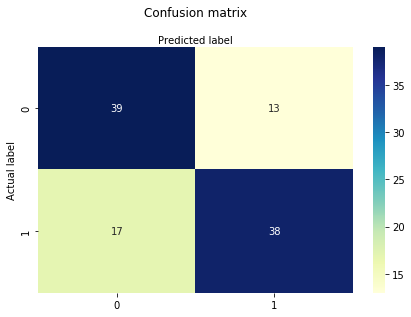

In [46]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [47]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.719626168224299
Precision: 0.7450980392156863
Recall: 0.6909090909090909
Log loss=  0.5582834570159061


In [48]:
# Retrieve the non-normalized game stats
prediction_probabilities = logreg.predict_proba(X_test)
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,train_rec,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,srs_sqr_t,srs_sqr_o,off_rating_sqr_t,off_rating_sqr_o,predicted_result,pred_win_prob
7,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,0,1,2010,Win,-0.749269,3.78,0.700,-0.507560,0.320302,0.434,0.424,0.715,-0.033247,75.240000,-0.514447,-0.145793,-1.261299,1.207568,-0.319048,1.384405,-0.184231,-0.399956,2010,0.070357,10.39,0.656,-0.677017,0.321882,0.475,0.387,0.734,0.340836,73.850000,-0.491697,-0.067506,-0.291013,-1.679184,1.050842,-0.188247,-0.118063,-1.446065,Atlantic 10,Big East,77.0,55.0,54,74.0,59.0,84.0,72.0,49.0,80.0,16.0,19.0,16,17.0,16.0,31.0,19.0,13.0,42.0,0,0,-1.036057,-0.242696,-0.209437,-0.144414,0,0.423448
28,2012,64,2012-03-16,5,Temple,8598d1b6-106b-4083-a512-2e495729525a,12,South Florida,55af9c69-3675-4b9b-a882-96640b782fff,0,0,2011,Lose,-0.502079,4.94,0.750,0.335211,0.963723,0.469,0.435,0.719,0.321167,77.743750,-0.514447,0.567120,-1.261299,0.010110,0.330008,0.592680,0.239479,-0.777260,2011,-0.640966,7.29,0.611,-2.871239,-1.863633,0.437,0.386,0.705,-0.731992,69.133333,-0.491697,-0.067506,-1.587198,-1.093448,1.050842,-0.915315,-1.996657,-1.813265,American Athletic,American Athletic,36.0,29.0,28,35.0,22.0,34.0,20.0,20.0,42.0,70.0,51.0,60,53.0,59.0,66.0,60.0,52.0,47.0,0,1,-0.839077,-0.978364,0.214898,-1.922791,0,0.272688
34,2017,32,2017-03-19,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,3,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,0,0,2016,Lose,-0.181258,4.62,0.714,-0.086174,0.105828,0.454,0.406,0.668,2.093239,77.840000,0.057996,-0.145793,0.524285,0.608839,-0.319048,-0.199045,-0.301438,0.354651,2016,0.884237,8.38,0.846,0.918782,0.103330,0.481,0.403,0.712,-1.089601,77.917949,-0.491697,-0.067506,1.005171,0.078025,-0.268590,-0.188247,0.939860,-0.344465,Atlantic 10,Pacific 12,48.0,40.0,48,53.0,43.0,37.0,52.0,31.0,31.0,13.0,14.0,8,11.0,7.0,16.0,12.0,9.0,24.0,-1,1,-0.525293,1.009125,-0.325162,0.939152,0,0.134195
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,0,0,2012,Lose,-2.296836,-5.80,0.588,0.967289,2.465038,0.479,0.468,0.691,0.321167,80.676471,0.057996,0.567120,-2.154090,-0.588619,1.628119,-0.199045,0.282067,1.486563,2012,-2.078076,-2.28,0.583,-1.674391,-0.115221,0.421,0.428,0.699,0.698445,72.988889,-0.491697,-0.067506,-2.019259,1.249497,-0.268590,0.538822,-1.258236,-0.711665,Northeast,Colonial,163.0,182.0,171,182.0,173.0,185.0,193.0,179.0,134.0,169.0,183.0,183,184.0,179.0,179.0,168.0,182.0,155.0,0,0,-1.383307,-1.444665,0.258067,-1.246007,0,0.333821
43,2017,64,2017-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,1,2016,Win,0.327585,2.19,0.853,-0.296867,-1.609960,0.496,0.412,0.745,-1.450904,69.458824,-1.086891,-2.284529,0.524285,-1.786077,-0.968104,-1.782496,1.685544,-2.663779,2016,-0.329351,3.77,0.743,0.120882,0.321882,0.461,0.422,0.705,1.413664,79.537143,0.055431,-0.801811,0.573110,1.249497,0.391126,0.538822,-0.465846,0.022735,West Coast,Atlantic 10,25.0,25.0,11,20.0,18.0,14.0,23.0,17.0,26.0,50.0,43.0,46,54.0,30.0,52.0,44.0,22.0,50.0,0,0,0.107053,-0.697232,1.733622,-0.487710,1,0.679556


In [50]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
missed_predictions[['season_t','round','team_t','seed_t','conf_name_t', 'team_o','seed_o', 
                    'conf_name_o','top_conf','predicted_result','game_result','pred_win_prob']]


,season_t,round,team_t,seed_t,conf_name_t,team_o,seed_o,conf_name_o,top_conf,predicted_result,game_result,pred_win_prob
358,2015,32,Villanova,1,Big East,North Carolina State,8,Atlantic Coast,-1,1,0,0.918203
488,2016,64,West Virginia,3,Big 12,Stephen F. Austin,14,Southland,1,1,0,0.876352
208,2010,16,Syracuse,1,Atlantic Coast,Butler,5,Big East,1,1,0,0.783319
366,2012,64,UNLV,6,Mountain West,Colorado,11,Pacific 12,-1,1,0,0.690532
132,2015,4,Kentucky,1,Southeastern,Wisconsin,1,Big Ten,0,1,0,0.690371
52,2010,64,Utah State,12,Mountain West,Texas A&M,5,Southeastern,-1,1,0,0.686681
514,2013,16,Miami (FL),2,Atlantic Coast,Marquette,3,Big East,1,1,0,0.645421
490,2011,68,Alabama State,16,Southwestern Athletic,UTSA,16,Conference USA,0,1,0,0.632402
292,2010,8,Tennessee,6,Southeastern,Michigan State,5,Big Ten,0,1,0,0.627768
440,2012,64,Notre Dame,7,Atlantic Coast,Xavier,10,Big East,1,1,0,0.548582


In [52]:
utils.print_game_info(test_games, 2015, 32, 'Villanova')

                                    Villanova       North Carolina State     Stat Upset
Seed                              1                                  8           True  (L)
SAG                              6.00                              32.00         True  (L)
WLK                              4.00                              33.00         True  (L)
WOL                              2.00                              40.00         True  (L)
RTH                              2.00                              32.00         True  (L)
COL                              2.00                              40.00         True  (L)
POM                              5.00                              38.00         True  (L)
DOL                              2.00                              40.00         True  (L)
RPI                              2.00                              39.00         True  (L)
MOR                              4.00                              22.00         True  (L)
Al

In [53]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

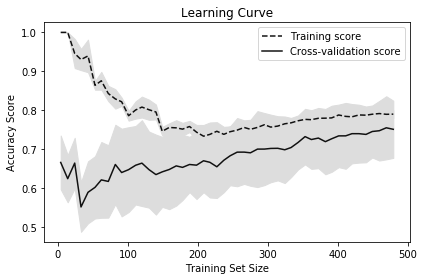

In [54]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Cross Validation Evaluation

In [55]:
scores = cross_val_score(LogisticRegression(), X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.7532118475514702


### Recursive Feature Elimination

In [81]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg,12)
fit = rfe.fit(X,y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 12
Selected Features: [False False  True False  True  True False  True  True  True False False
  True  True  True  True  True False False False False  True]
Feature Ranking: [ 8  9  1  2  1  1  7  1  1  1 11  3  1  1  1  1  1 10  6  4  5  1]


In [82]:
X_train.iloc[:,fit.support_].head()

,top_conf,srs_sqr_t,srs_sqr_o,off_rating_sqr_o,delta_margin_victory_avg,fg_pct,allow_def_rebs_avg,ft_pct,delta_to_net_avg,win_pct,off_rating,delta_srs
140,0,0.159212,-1.343002,-0.707030,0.450177,0.069,-3.621311,-0.008,1.325804,0.081,1.052428,1.615448
293,0,-0.144156,0.337619,0.133314,-0.543713,0.000,-2.449838,-0.044,1.985520,0.030,-1.024815,-0.342336
368,-1,-1.367465,0.413417,-1.388465,-0.944750,0.032,-0.653651,0.016,1.479134,-0.132,0.846440,-1.929348
53,1,0.437045,-1.021493,0.696904,0.967795,-0.006,-0.627666,-0.085,-0.239021,0.118,-0.882773,1.247297
33,0,0.945695,1.700296,1.082798,0.359944,-0.007,-0.653651,0.034,-0.699375,-0.015,-0.105227,-0.383090
